#### Exercício extra sobre classificação de redes

Neste exercício são realizadas classificações de redes utilizando classificador k-vizinhos com diferentes métodos de redução de dimensão.

As redes utilizadas foram retiradas de https://networkrepository.com/

In [1]:
import networkx as nx

def OpenNetwork(filename, digraph=True): 
    """Abre arquivos de redes complexas que podem ter linhas de comentário iniciadas com %

    Args:
        filename (string): Nome do arquivo
        digraph (bool, optional): Indica se retorno será um grafo direcionado ou não. Defaults to True.

    Returns:
        networkx.: networkx Digrafo ou Graph dependendo do parâmetro digraph.
    """
    G = nx.DiGraph()

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith("%"):
                source, target, capacity = line.split()
                source = int(source)
                target = int(target)
                capacity = float(capacity)
                G.add_edge(source, target, capacity=capacity)
    if digraph:
        return G
    else:
        return G.to_undirected()

In [2]:
import networkx as nx
import os
import matplotlib.pyplot as plt

def largest_connected_component(G):
    """
    Obtém o maior componente conectado de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.

    Returns:
        networkx.Graph: O maior componente conectado.
    """
    G = G.to_undirected()
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    return G

def remove_selfloops(G):
    """
    Remove as arestas que conectam um vértice a ele mesmo em uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.

    Returns:
        networkx.Graph: A rede complexa sem as arestas que conectam um vértice a ele mesmo.
    """
    G = G.to_undirected()
    for u, v in G.edges():
        if u == v: 
            G.remove_edge(u, v)
    return G

def get_name(txt_filename):
    """
    Obtém o nome do arquivo sem a extensão.

    Args:
        txt_filename (str): O nome do arquivo com extensão.

    Returns:
        str: O nome do arquivo sem a extensão.
    """
    name = os.path.basename(txt_filename)
    return os.path.splitext(name)[0]

def plot_graph(G):
    """
    Plota a representação gráfica de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.
    """
    pos = nx.spring_layout(G, seed=42)
    d = dict(G.degree())
    nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)
    plt.title(f"Test Case: {G.name}\n|V|= {len(G)} |E|={G.number_of_edges()}")
    plt.show()

In [3]:
import networkx as nx
import numpy as np
import itertools
import math

def moment_of_degree_distribution(G, m):
    """
    Calcula o momento m da distribuição de grau de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.
        m (int): O momento desejado.

    Returns:
        float: O valor do momento m da distribuição de grau.
    """
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i) ** m
    M = M / N
    return M


def degree_distribution(G):
    """
    Calcula a distribuição de grau de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.

    Returns:
        tuple: Uma tupla contendo os valores de grau possíveis e as probabilidades correspondentes.
    """
    paths = dict(nx.shortest_path_length(G))
    lengths = list(itertools.chain.from_iterable(paths[u].values() for u in paths))
    maxk = np.max(lengths)
    mink = np.min(lengths)
    lvalues = np.arange(mink, maxk + 1)  # valores possíveis de grau
    Plength = np.zeros(maxk + 1)  # P(k)
    for k in lengths:
        Plength[k] = Plength[k] + 1
    Plength = Plength / sum(Plength)  # a soma dos elementos de P(k) deve ser igual a um
    return lvalues, Plength


def shannon_entropy(G):
    """
    Calcula a entropia de Shannon de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.

    Returns:
        float: O valor da entropia de Shannon.
    """
    l, Pl = degree_distribution(G)
    H = 0
    for p in Pl:
        if p > 0:
            H = H - p * math.log(p, 2)
    return H


def measures(G):
    """
    Calcula medidas estatísticas de uma rede complexa.

    Args:
        G (networkx.Graph): A rede complexa.

    Returns:
        numpy.array: Um vetor contendo as medidas calculadas.
    """
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)

    k1 = moment_of_degree_distribution(G, 1)
    k2 = moment_of_degree_distribution(G, 2)

    variance = moment_of_degree_distribution(G, 2) - moment_of_degree_distribution(G, 1) ** 2

    av_cl = nx.average_clustering(G)

    l = nx.average_shortest_path_length(G)
    r = nx.degree_assortativity_coefficient(G)

    s = shannon_entropy(G)

    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    dc = np.mean(list(degree_centrality.values()))
    bc = np.mean(list(betweenness_centrality.values()))
    cc = np.mean(list(closeness_centrality.values()))

    measures_vector = np.array([k1, k2, variance, av_cl, l, r, s, dc, bc, cc])

    return measures_vector


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import umap

def classitication(G):	
	"""_summary_

	Args:
		G (_type_): _description_

	Returns:
		_type_: _description_
	"""
	n_nets = 30
	result = []
	result.append(G.name)
	N = len(G)
 		
	X_net = measures(G)
	k1 = X_net[0]
	cl = ['ER','WS','BA']
	
	X = []
	Y = []
 
	#ER networks
	p = k1/(N-1)
	for i in range(n_nets):
		GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
		GER = largest_connected_component(GER)
		GER = nx.convert_node_labels_to_integers(GER, first_label=0)
		x = measures(GER)
		X.append(x)
		Y.append(0)
	
	#WS networks
	k = int(k1)
	p = 0.05 #probability of rewiring
	for i in range(n_nets):
		GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
		GWS = largest_connected_component(GWS)
		GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
		x = measures(GWS)
		X.append(x)
		Y.append(1)
	
	# BA networks
	for i in range(n_nets):
		GBA = nx.barabasi_albert_graph(N, k)    
		GBA = largest_connected_component(GBA)
		GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
		x = measures(GBA)
		X.append(x)
		Y.append(2)
		
	X = np.array(X)
	Y = np.array(Y)
	
	scaler = StandardScaler().fit(X)
	X = scaler.transform(X)
	
	X_net = np.array(X_net)
	X_net = X_net.reshape(1,len(X_net)) 
	X_net = scaler.transform(X_net)
	
	
	# Reduce dimension to 2 with PCA Principal Component Analysis
	pca = make_pipeline(StandardScaler(), PCA(n_components=2))
	
	# Reduce dimension to 2 with Linear Discriminant Analysis
	lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))
	
	# Reduce dimension to 2 with Neighborhood Component Analysis
	nca = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(n_components=2))
	
	uma = umap.UMAP()
	
	dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca), ("UMAP", uma)]
	
	# Define colors for each class and for the test case
	colors = ['blue', 'green', 'orange', 'red']
	
	k = 5
	knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
	
	plt.figure(figsize=(12, 12))
	
	# Plot each method's projection
	for i, (name, model) in enumerate(dim_reduction_methods):
		plt.subplot(2,2,i+1)
	
		# Fit the method's model
		model.fit(X, Y)
	
		# Embed the data set in 2 dimensions using the fitted model
		X_embedded = model.transform(X)
	
		# Embed the test case in 2 dimensions using the fitted model
		X_test_embedded = model.transform(X_net.reshape(1, -1))
	
		# Make predictions using KNN
		knn.fit(X_embedded, Y)
			
		# Find the k nearest neighbors to the center point
		_, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
		neighbors = X_embedded[indices][0]
	
		# Calculate the radius of the circle
		radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))
	
		# Draw a circle around the center point with the calculated radius
		circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
		plt.gca().add_artist(circle)
		
		y_pred = knn.predict(X_test_embedded)
		
		_class = cl[int(np.mean(y_pred))]
		result.append(_class)
	
		# Plot the projected points with different colors for each class and the test case
		for j in range(len(cl)):
			plt.scatter(
				X_embedded[Y == j, 0],
				X_embedded[Y == j, 1],
				c=colors[j],
				s=30,
				label=cl[j],
			)
		plt.scatter(
			X_test_embedded[:, 0],
			X_test_embedded[:, 1],
			c=colors[-1],
			s=100,
			marker="X",
			label="Test Case",
		)
		plt.title(
			f"{name}, KNN (k={k}) - Predicted Class: {cl[int(np.mean(y_pred))]}"
		)
		plt.legend()
		plt.axis('equal')
	plt.show()
 
	return result

In [14]:
table_results = []

Test Case: bio-CE-GT  |V|= 924  |E|= 3239


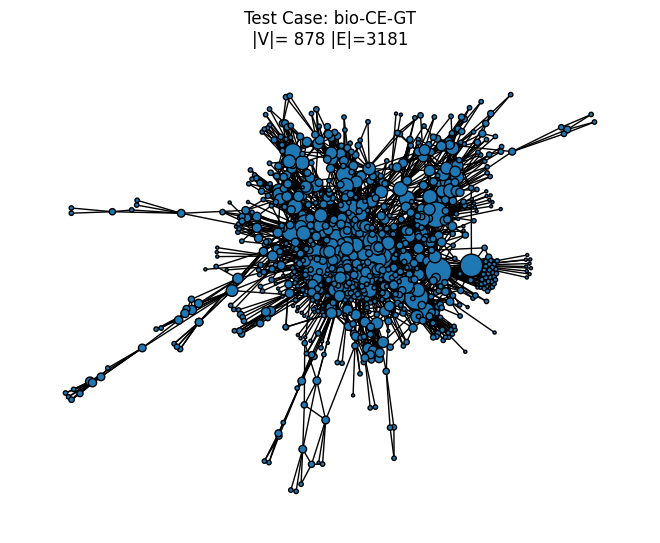

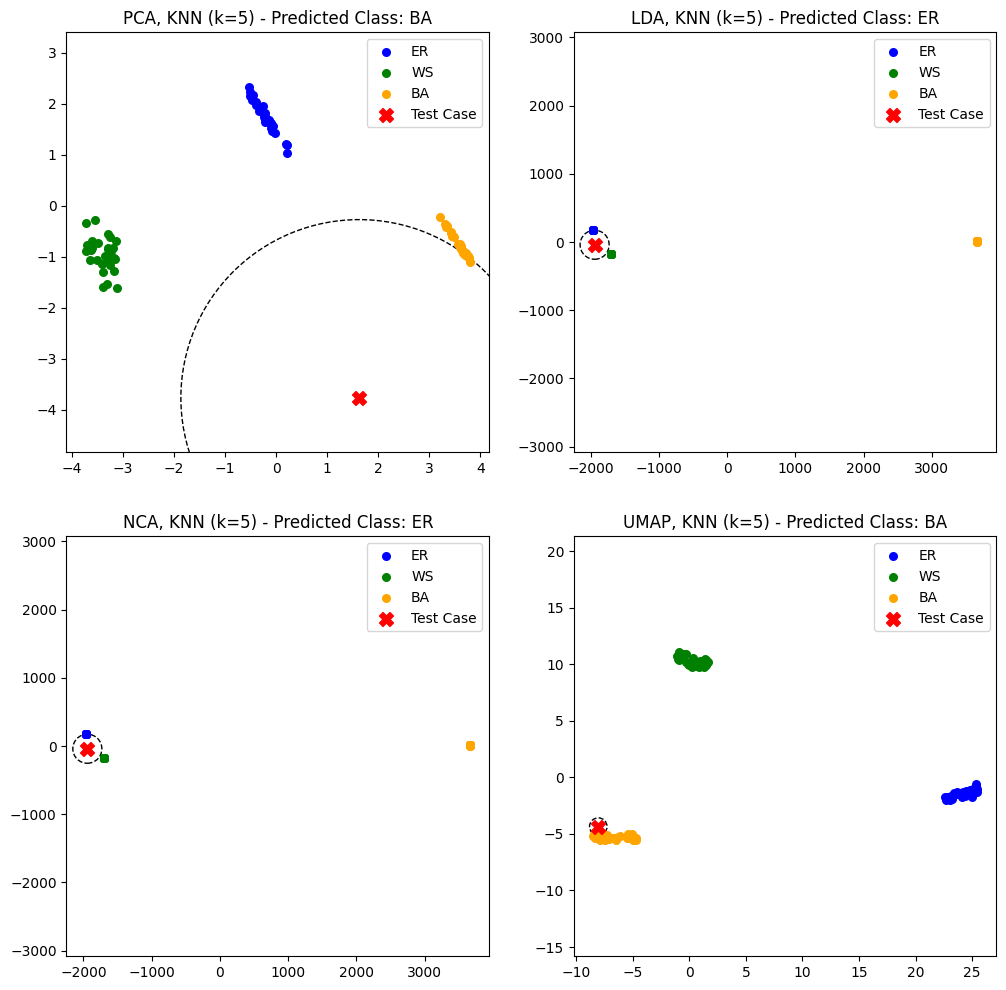

Test Case: bio-CE-LC  |V|= 1387  |E|= 1648


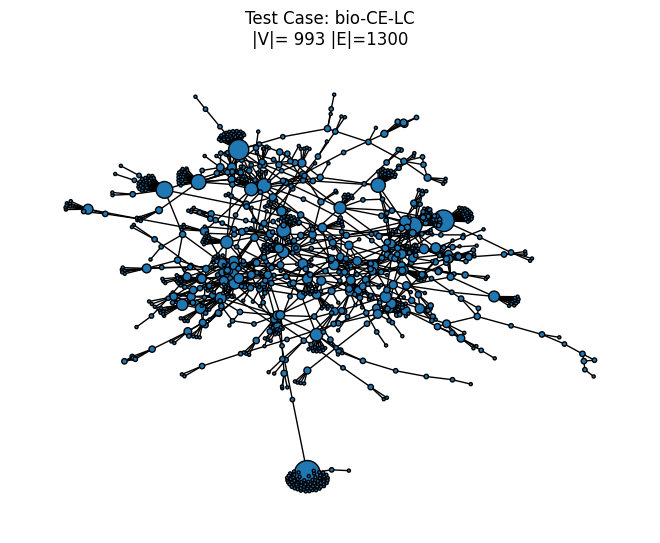

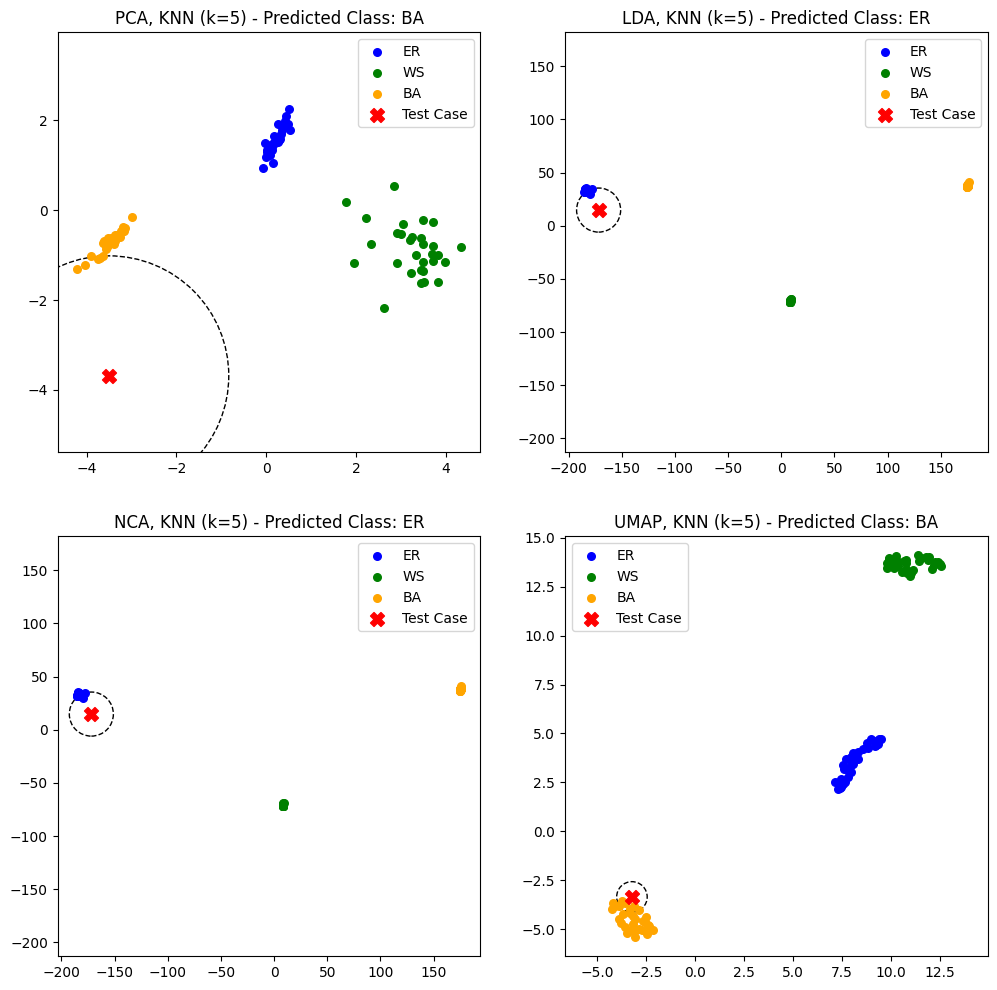

Test Case: bio-grid-mouse  |V|= 1450  |E|= 1636


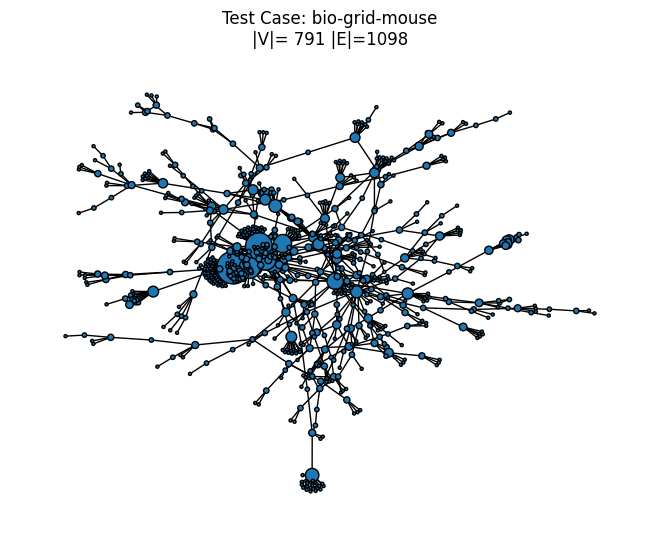

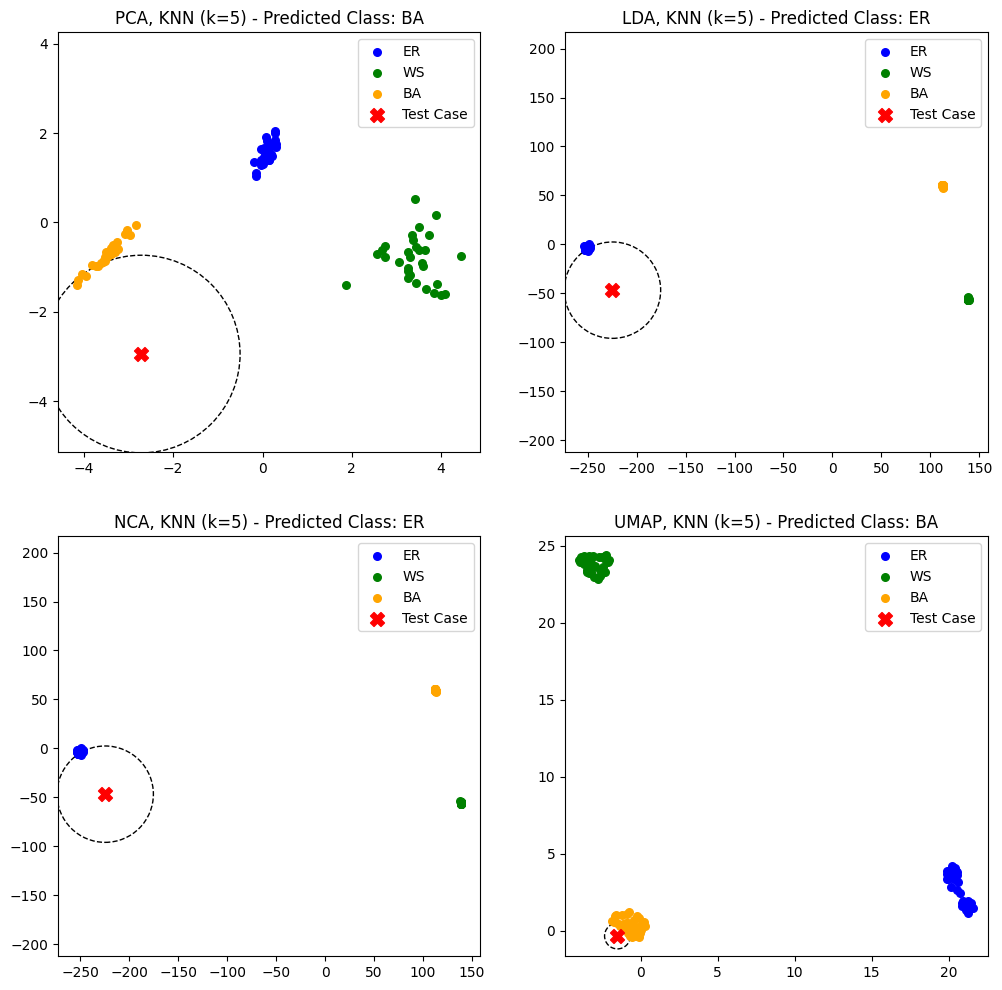

In [15]:
directory = 'dataset/biology'
bio_files = os.listdir(directory)

for txt_filename in bio_files:
    G = OpenNetwork(directory + '/' + txt_filename, digraph=False)
    G.name = get_name(txt_filename)
    print("Test Case:", G.name, " |V|=", len(G), " |E|=", G.number_of_edges())
    G = largest_connected_component(G)
    G = remove_selfloops(G)
    plot_graph(G)
    result = classitication(G)
    table_results.append(result)

Test Case: power-1138-bus  |V|= 1138  |E|= 2596


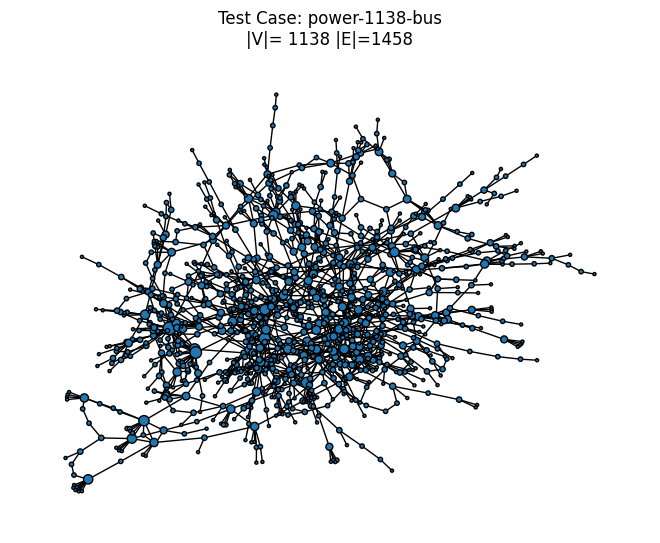

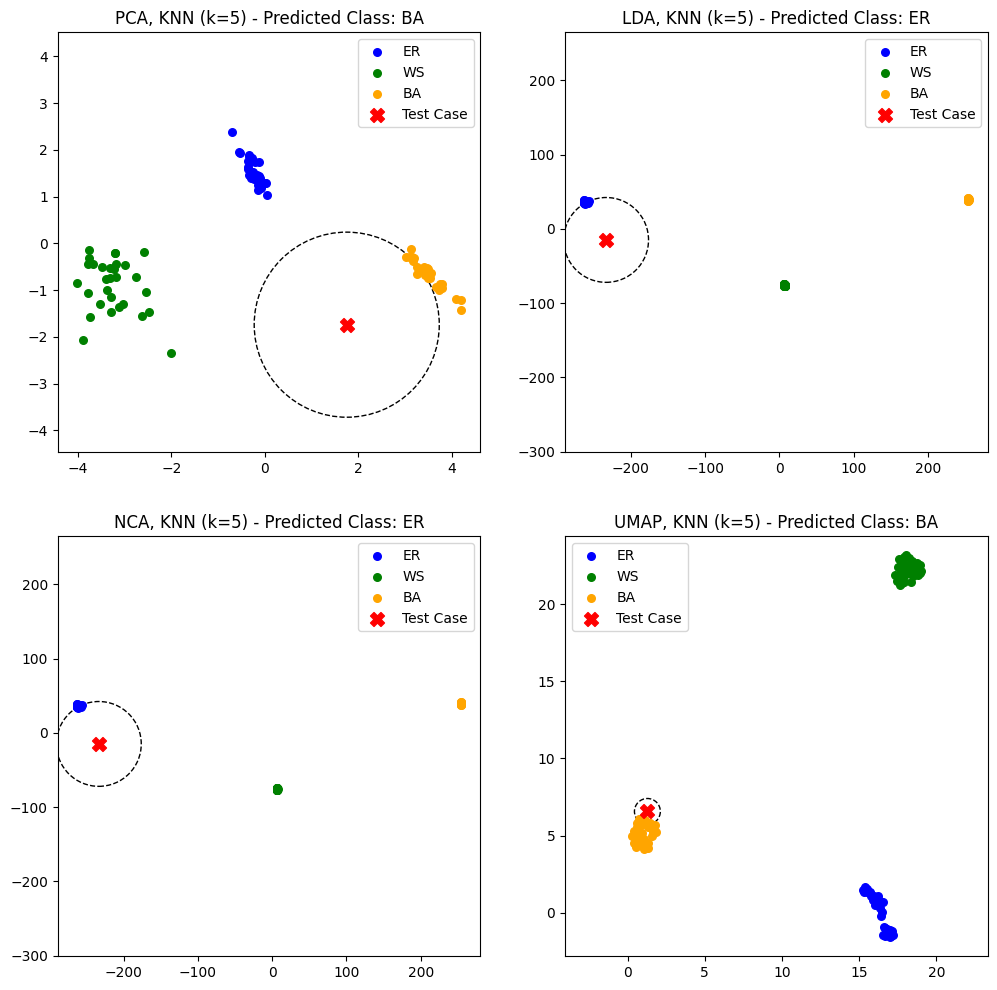

Test Case: power-494-bus  |V|= 494  |E|= 1080


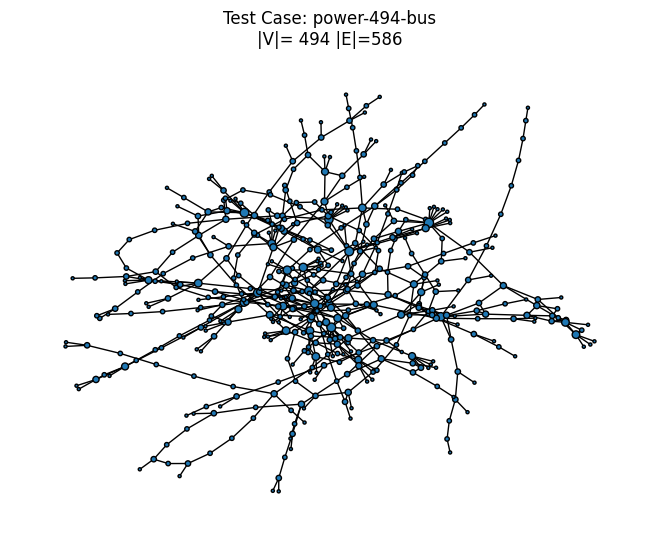

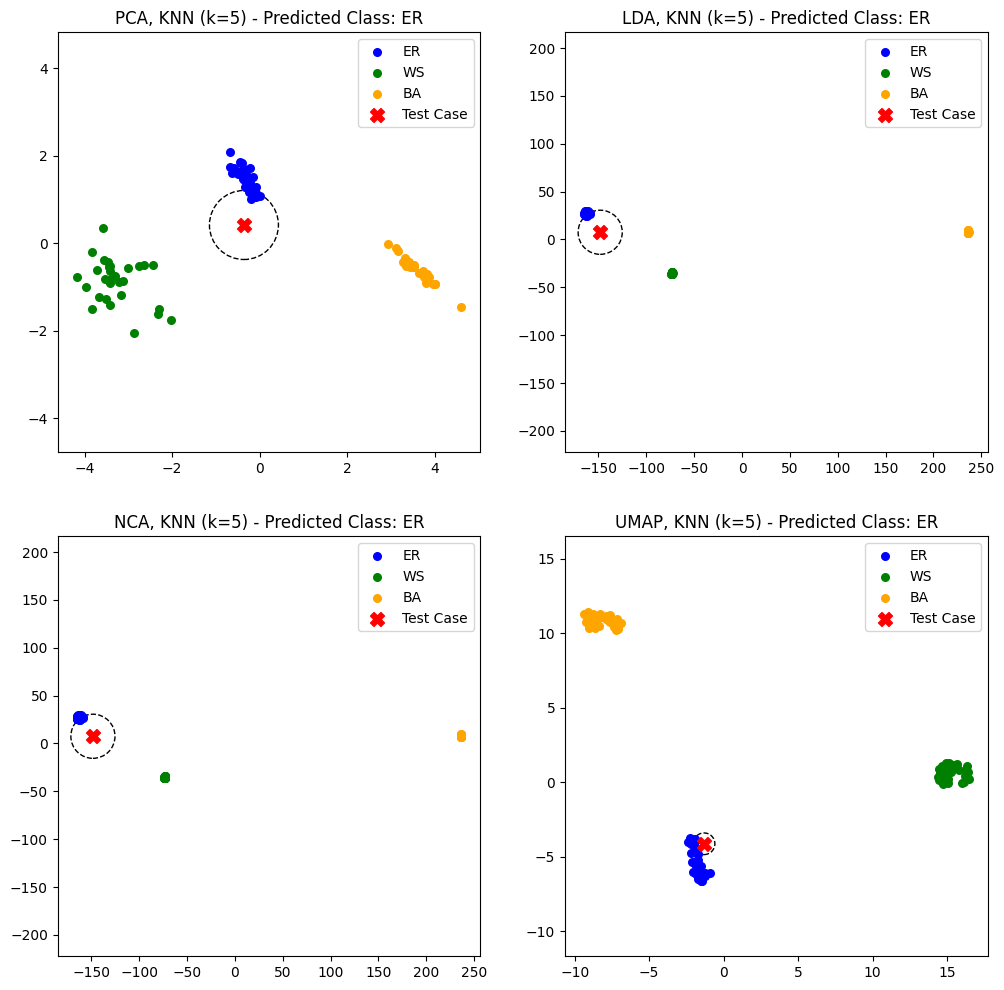

Test Case: power-662-bus  |V|= 662  |E|= 1568


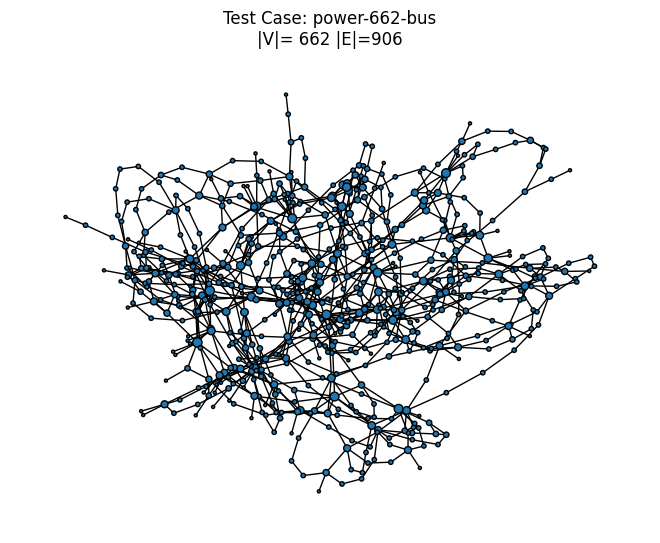

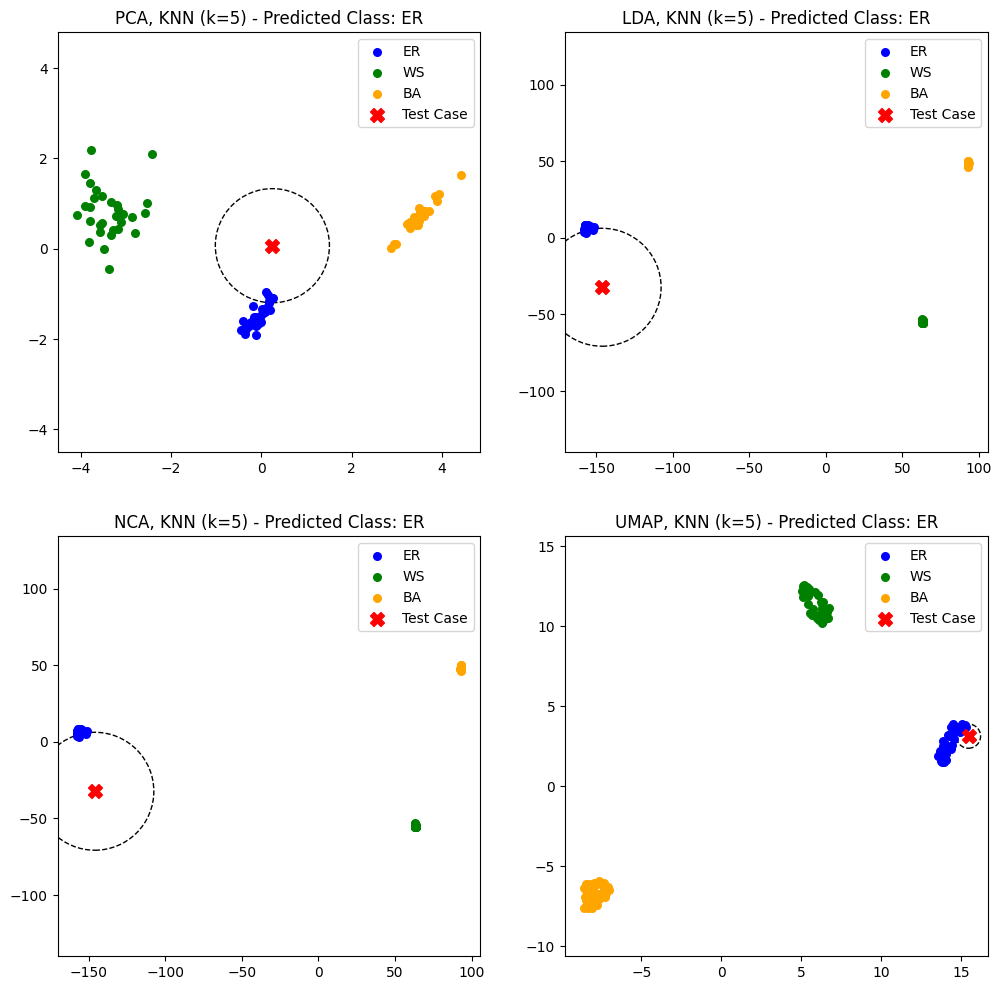

In [16]:
directory = 'dataset/tecnology'
bio_files = os.listdir(directory)

for txt_filename in bio_files:
    G = OpenNetwork(directory + '/' + txt_filename, digraph=False)
    G.name = get_name(txt_filename)
    print("Test Case:", G.name, " |V|=", len(G), " |E|=", G.number_of_edges())
    G = largest_connected_component(G)
    G = remove_selfloops(G)
    plot_graph(G)
    result = classitication(G)
    table_results.append(result)

Test Case: fb-pages-food  |V|= 620  |E|= 2102


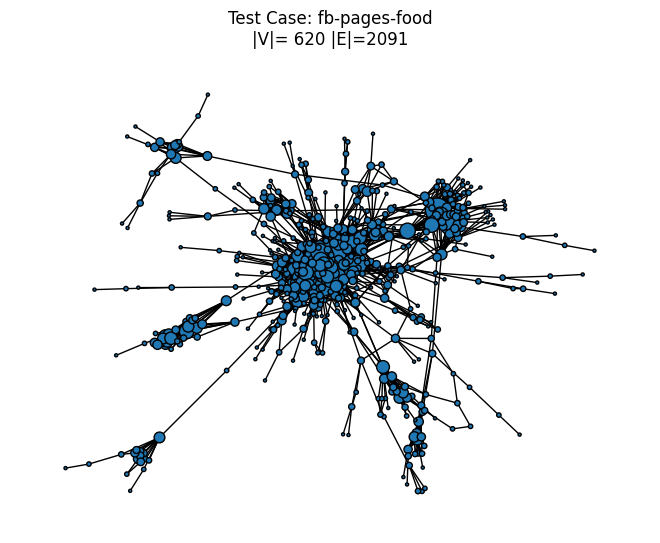

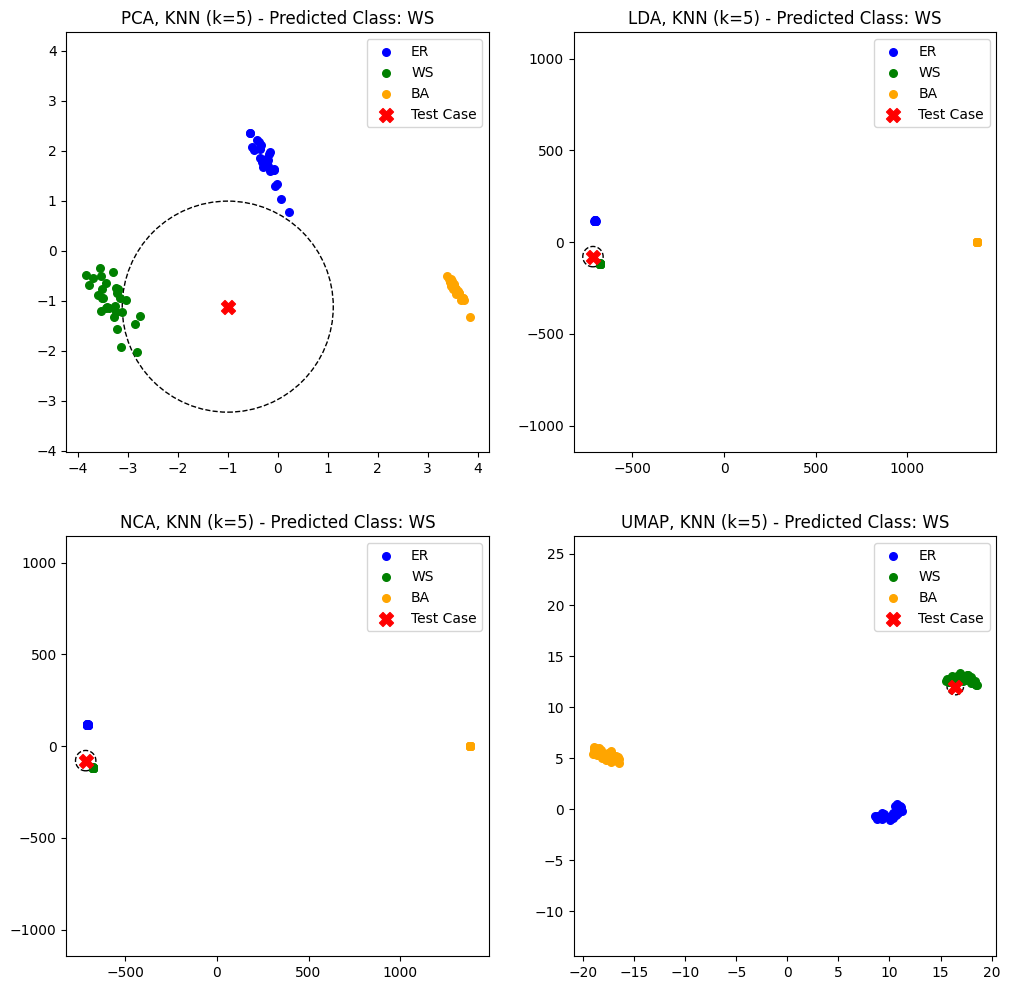

Test Case: fb-pages-tvshow  |V|= 3892  |E|= 17262


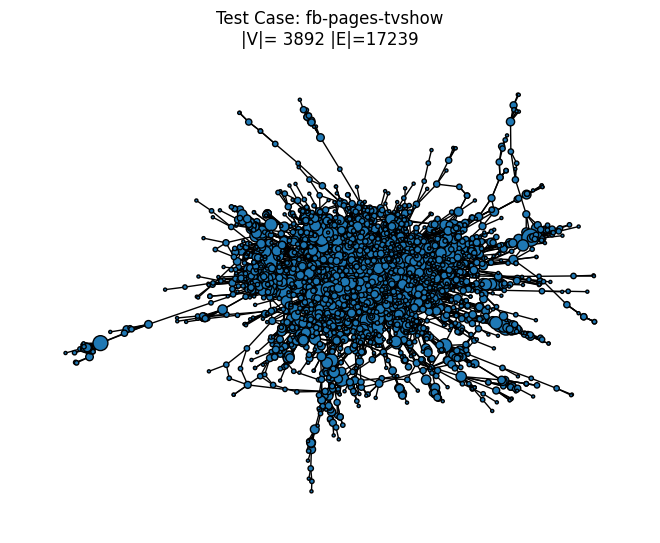

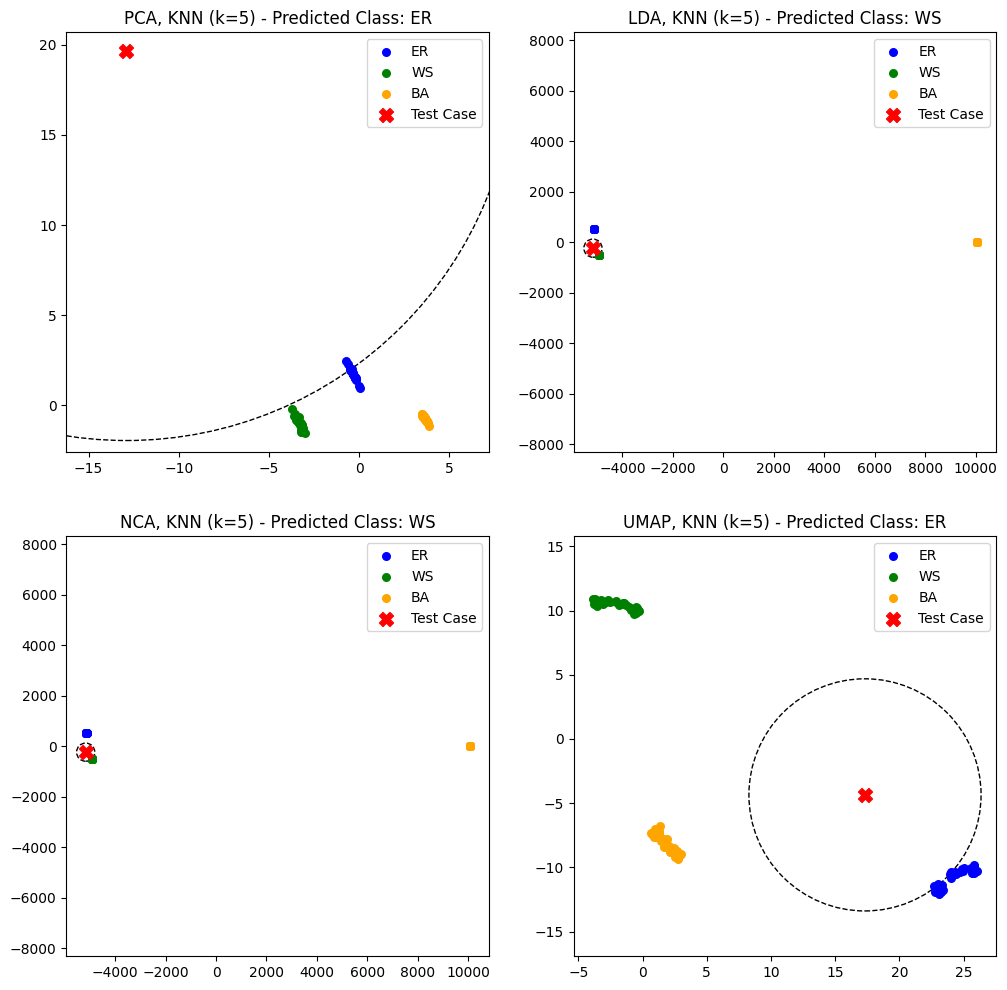

Test Case: soc-advogato  |V|= 6551  |E|= 43427


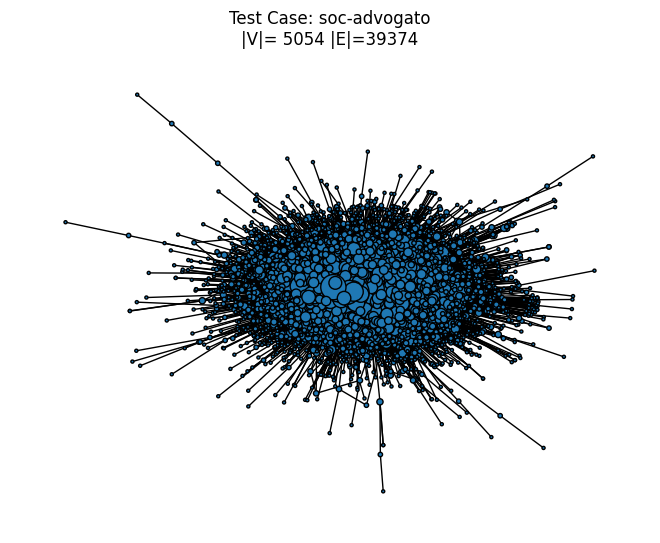

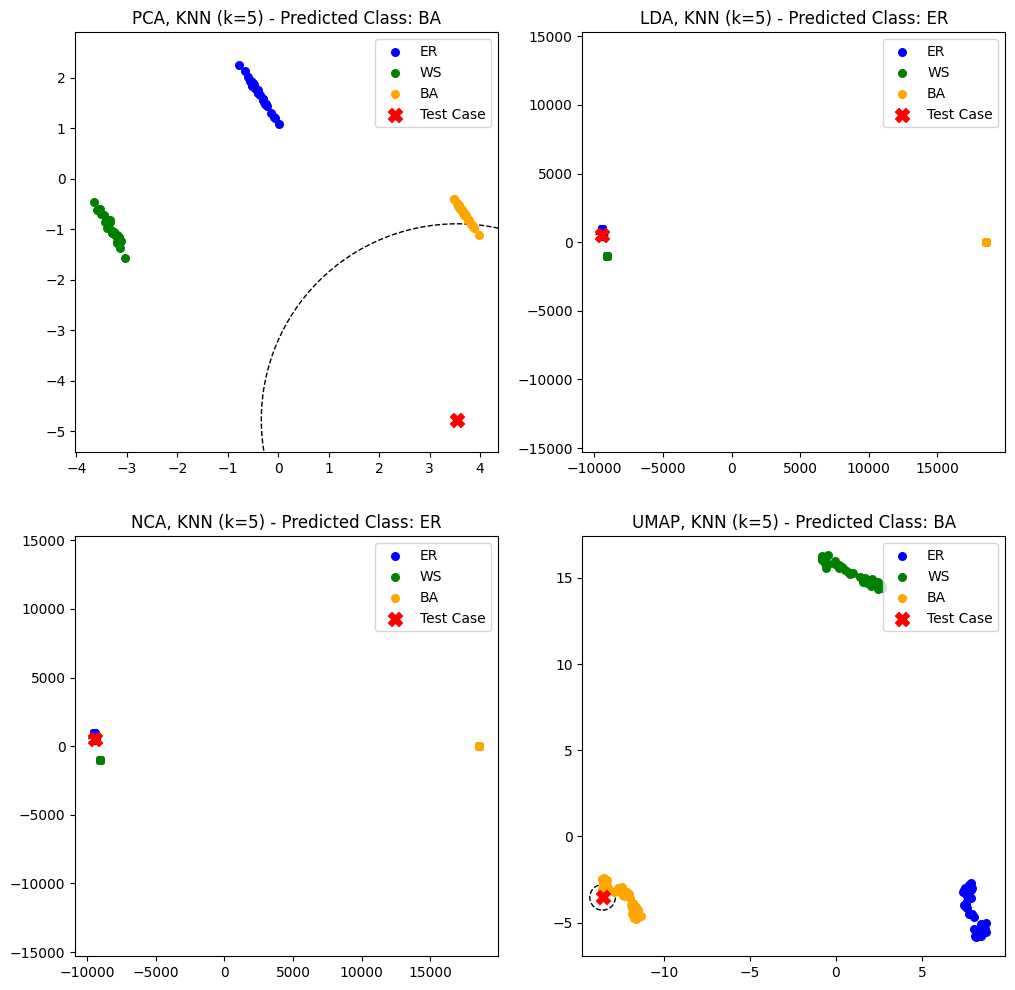

In [28]:
directory = 'dataset/social networks'
bio_files = os.listdir(directory)

for txt_filename in bio_files:
    G = OpenNetwork(directory + '/' + txt_filename, digraph=False)
    G.name = get_name(txt_filename)
    print("Test Case:", G.name, " |V|=", len(G), " |E|=", G.number_of_edges())
    G = largest_connected_component(G)
    G = remove_selfloops(G)
    plot_graph(G)
    result = classitication(G)
    table_results.append(result)

In [29]:
import pandas as pd

columns_names = ['Nome', 'PCA', 'LDA', 'NCA', 'UMAP']
df = pd.DataFrame(table_results, columns=columns_names)
display(df)

,Nome,PCA,LDA,NCA,UMAP
0,bio-CE-GT,BA,ER,ER,BA
1,bio-CE-LC,BA,ER,ER,BA
2,bio-grid-mouse,BA,ER,ER,BA
3,power-1138-bus,BA,ER,ER,BA
4,power-494-bus,ER,ER,ER,ER
5,power-662-bus,ER,ER,ER,ER
6,fb-pages-food,WS,WS,WS,WS
7,fb-pages-tvshow,ER,WS,WS,ER
8,soc-advogato,BA,ER,ER,BA
